In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Model and preprocessing libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, confusion_matrix, classification_report,
                           roc_auc_score, roc_curve, precision_recall_curve)

# For handling class imbalance
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Statistical testing
from scipy.stats import ttest_ind, zscore, pearsonr

import joblib

### DATA LOADING

In [3]:
# Load the dataset
df = pd.read_csv('P600_pronostico_dataset.csv', sep=';')
print("Dataset loaded successfully!")

# Basic dataset exploration
print(f"\n Dataset Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

print(f"\nFirst 5 rows:")
print(df.head())

print(f"\nDataset Info:")
print(df.info())

print(f"\nBasic Statistics:")
print(df.describe())

Dataset loaded successfully!

 Dataset Shape: (6000, 6)
Columns: ['ID', 'age', 'systolic_bp', 'diastolic_bp', 'cholesterol', 'prognosis']

First 5 rows:
   ID        age  systolic_bp  diastolic_bp  cholesterol    prognosis
0   0  77.196340    85.288742     80.021878    79.957109  retinopathy
1   1  63.529850    99.379736     84.852361   110.382411  retinopathy
2   2  69.003986   111.349455    109.850616   100.828246  retinopathy
3   3  82.638210    95.056128     79.666851    87.066303  retinopathy
4   4  78.346286   109.154591     90.713220    92.511770  retinopathy

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            6000 non-null   int64  
 1   age           6000 non-null   float64
 2   systolic_bp   6000 non-null   float64
 3   diastolic_bp  6000 non-null   float64
 4   cholesterol   6000 non-null   float64
 5   

### DATA CLEANING & PREPROCESSING

In [4]:
# Check for missing values
print("Checking for missing values:")
missing_values = df.isnull().sum()
print(missing_values)

if missing_values.sum() == 0:
    print("No missing values found!")
else:
    print("Missing values detected. Implementing imputation strategy...")
    # Impute missing values with median (you can modify this based on your needs)
    for col in df.select_dtypes(include=[np.number]).columns:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].median(), inplace=True)

# Target variable encoding
print(f"\n Target variable distribution before encoding:")
print(df['prognosis'].value_counts())

# Encode target variable: 1 for retinopathy, 0 for no_retinopathy
df['target'] = df['prognosis'].map({'retinopathy': 1, 'no_retinopathy': 0})

print(f"\n Target variable encoded:")
print(f"   - retinopathy → 1")
print(f"   - no_retinopathy → 0")
print(f"\nEncoded target distribution:")
print(df['target'].value_counts())
print(f"Percentage: {df['target'].value_counts(normalize=True) * 100}")

# Drop ID column as it's not a predictive feature
print(f"\n🗑️ Dropping ID column...")
df_clean = df.drop('ID', axis=1)

print(f"Cleaned dataset shape: {df_clean.shape}")

Checking for missing values:
ID              0
age             0
systolic_bp     0
diastolic_bp    0
cholesterol     0
prognosis       0
dtype: int64
No missing values found!

 Target variable distribution before encoding:
prognosis
retinopathy       3087
no_retinopathy    2913
Name: count, dtype: int64

 Target variable encoded:
   - retinopathy → 1
   - no_retinopathy → 0

Encoded target distribution:
target
1    3087
0    2913
Name: count, dtype: int64
Percentage: target
1    51.45
0    48.55
Name: proportion, dtype: float64

🗑️ Dropping ID column...
Cleaned dataset shape: (6000, 6)


### EXPLORATORY DATA ANALYSIS (EDA)

3.1 TARGET DISTRIBUTION ANALYSIS


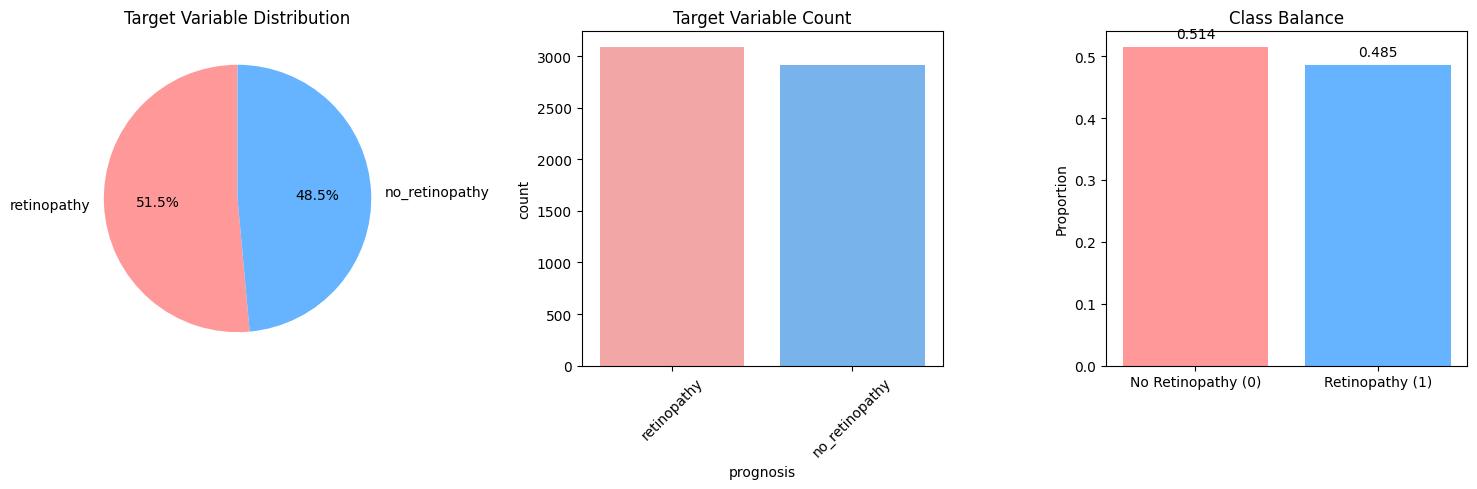

 Class Imbalance Ratio: 0.944
 Classes are reasonably balanced.

 3.2 FEATURE DISTRIBUTION ANALYSIS


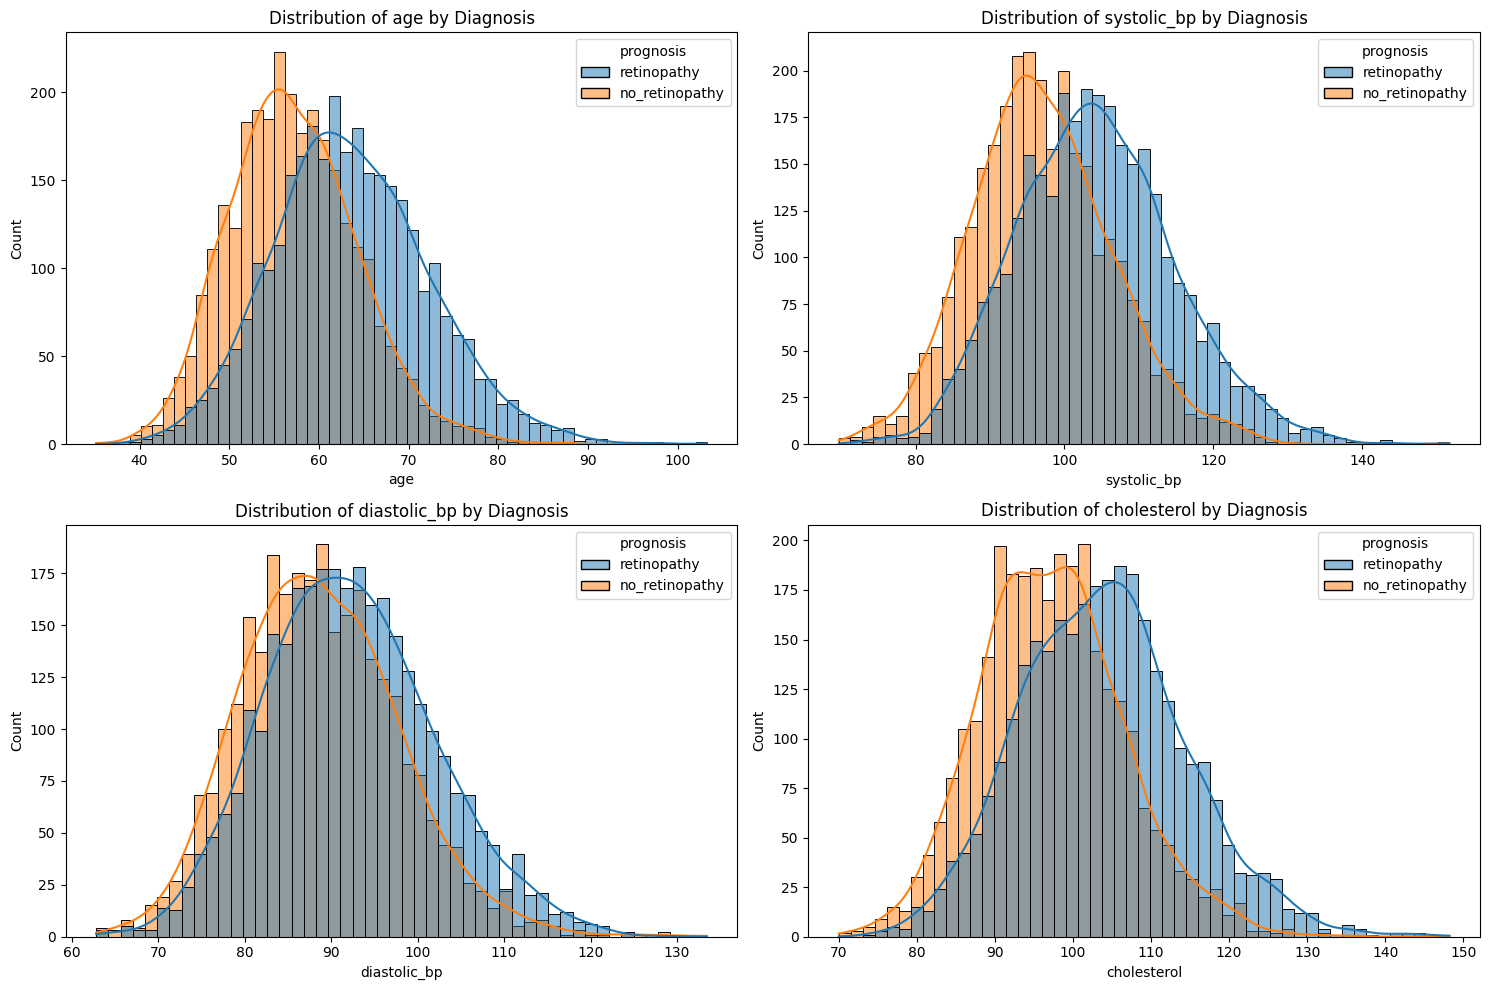

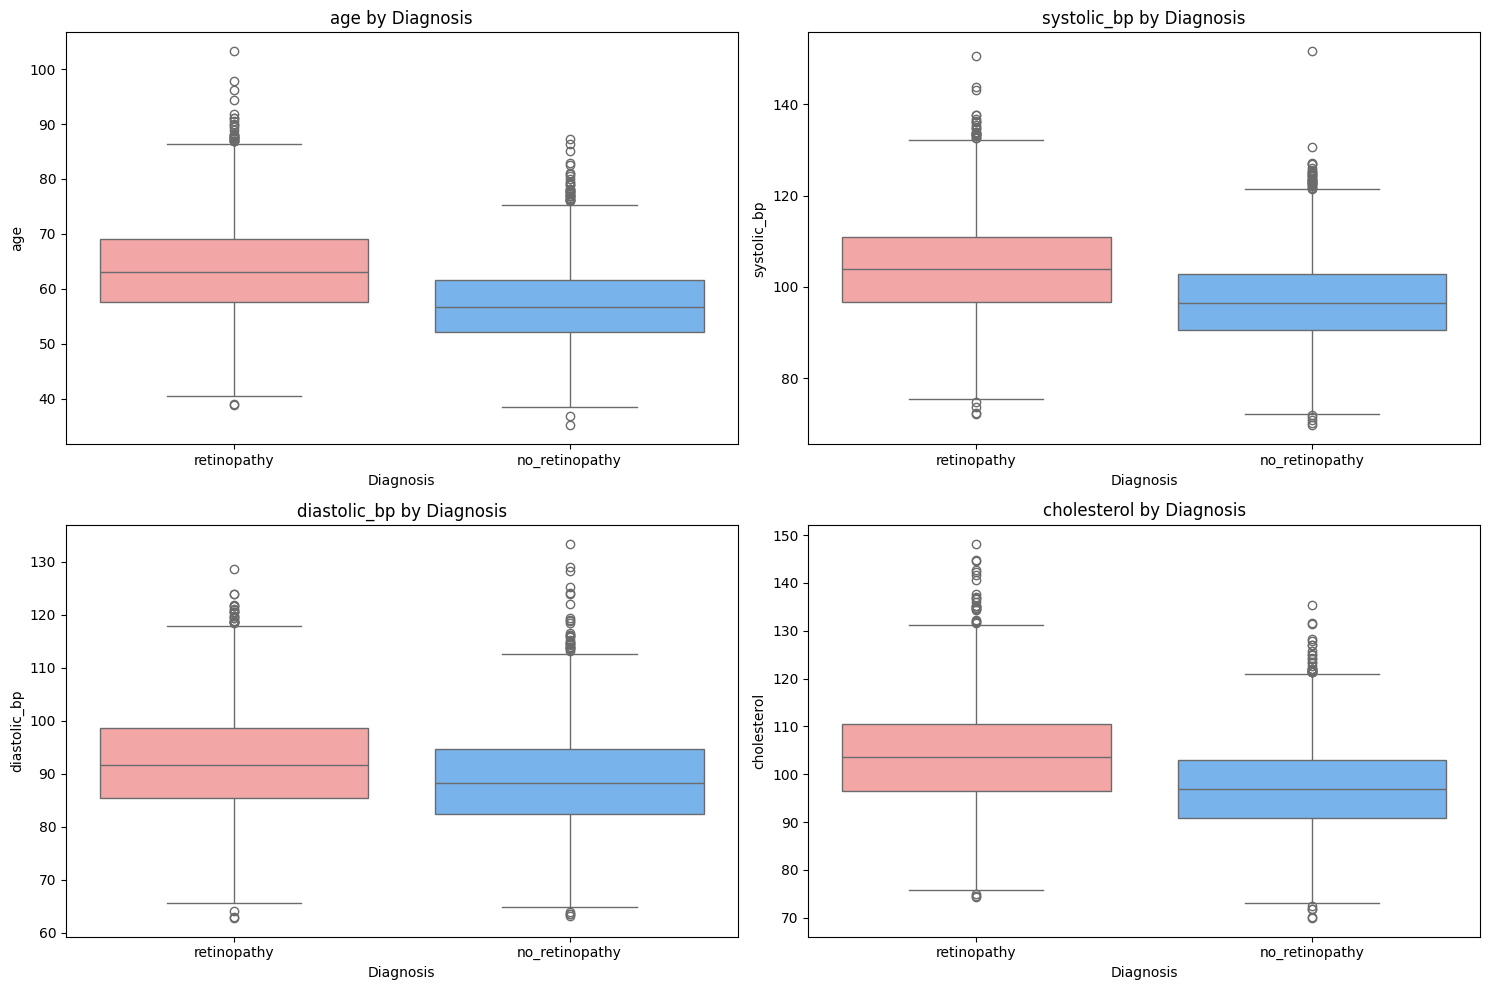


 3.3 STATISTICAL SUMMARY BY CLASS
Retinopathy Group Statistics:
               age  systolic_bp  diastolic_bp  cholesterol
count  3087.000000  3087.000000   3087.000000  3087.000000
mean     63.603982   104.216722     92.206868   103.828917
std       8.634555    10.540939      9.767414    10.554695
min      38.829539    72.084232     62.807105    74.320759
25%      57.686198    96.654242     85.346411    96.418177
50%      63.100530   103.839007     91.708558   103.626307
75%      69.156064   110.967377     98.556520   110.426158
max     103.279497   150.670082    128.568519   148.233544

No Retinopathy Group Statistics:
               age  systolic_bp  diastolic_bp  cholesterol
count  2913.000000  2913.000000   2913.000000  2913.000000
mean     57.136708    96.962551     88.702601    97.236411
std       7.111152     9.469584      9.184043     9.156912
min      35.164761    69.675429     63.131292    69.967453
25%      52.184788    90.562255     82.336667    90.876591
50%      56.7035

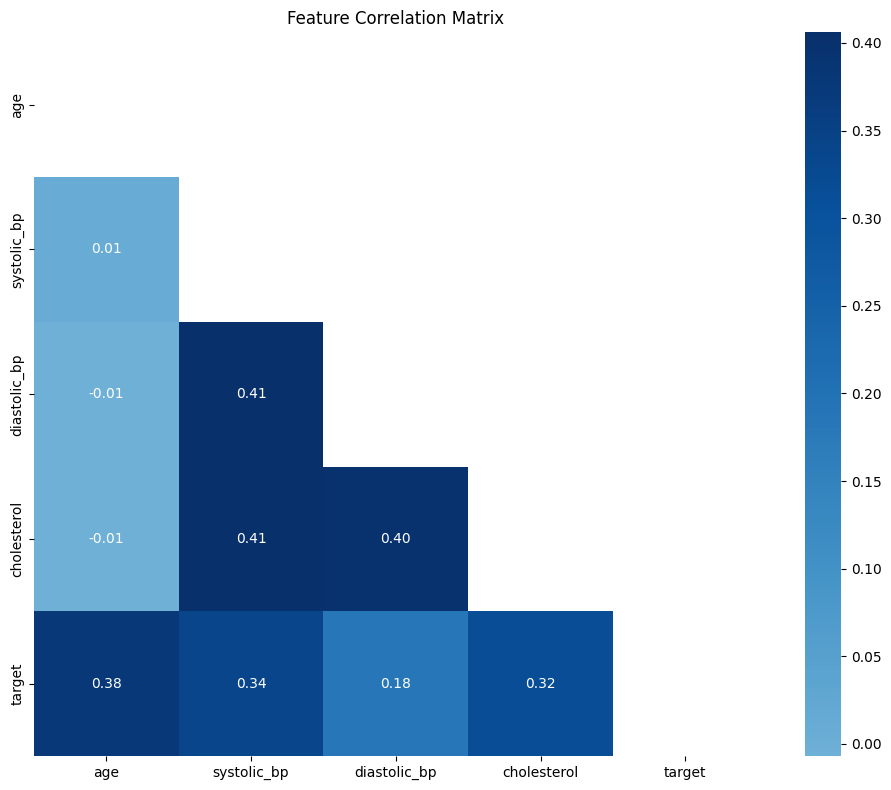

 No extremely high correlations detected.


In [5]:
# Target Distribution Analysis
print("3.1 TARGET DISTRIBUTION ANALYSIS")

plt.figure(figsize=(15, 5))

# Subplot 1: Count plot
plt.subplot(1, 3, 1)
target_counts = df_clean['prognosis'].value_counts()
colors = ['#ff9999', '#66b3ff']
plt.pie(target_counts.values, labels=target_counts.index, autopct='%1.1f%%',
        colors=colors, startangle=90)
plt.title('Target Variable Distribution')

# Subplot 2: Bar plot
plt.subplot(1, 3, 2)
sns.countplot(data=df_clean, x='prognosis', palette=colors)
plt.title('Target Variable Count')
plt.xticks(rotation=45)

# Subplot 3: Class balance analysis
plt.subplot(1, 3, 3)
class_balance = df_clean['target'].value_counts(normalize=True)
plt.bar(['No Retinopathy (0)', 'Retinopathy (1)'], class_balance.values, color=colors)
plt.title('Class Balance')
plt.ylabel('Proportion')
for i, v in enumerate(class_balance.values):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Check for class imbalance
imbalance_ratio = df_clean['target'].value_counts().min() / df_clean['target'].value_counts().max()
print(f" Class Imbalance Ratio: {imbalance_ratio:.3f}")
if imbalance_ratio < 0.5:
    print(" Significant class imbalance detected! Will use appropriate techniques.")
else:
    print(" Classes are reasonably balanced.")

# Feature Distribution Analysis
print("\n 3.2 FEATURE DISTRIBUTION ANALYSIS")

# Select features for analysis
features = ['age', 'systolic_bp', 'diastolic_bp', 'cholesterol']

# Create subplots for feature distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, feature in enumerate(features):
    # Histogram with KDE
    sns.histplot(data=df_clean, x=feature, hue='prognosis', kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature} by Diagnosis')
    axes[i].set_xlabel(feature)

plt.tight_layout()
plt.show()

# Boxplots for feature distributions by class
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, feature in enumerate(features):
    sns.boxplot(data=df_clean, x='prognosis', y=feature, ax=axes[i], palette=colors)
    axes[i].set_title(f'{feature} by Diagnosis')
    axes[i].set_xlabel('Diagnosis')

plt.tight_layout()
plt.show()

# Statistical Summary by Class
print("\n 3.3 STATISTICAL SUMMARY BY CLASS")

retinopathy_data = df_clean[df_clean['target'] == 1][features]
no_retinopathy_data = df_clean[df_clean['target'] == 0][features]

print("Retinopathy Group Statistics:")
print(retinopathy_data.describe())

print("\nNo Retinopathy Group Statistics:")
print(no_retinopathy_data.describe())

# 3.4 Correlation Analysis
print("\n 3.4 CORRELATION ANALYSIS")

# Correlation heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = df_clean[features + ['target']].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', center=0,
            square=True, mask=mask, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Check for high correlations
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            high_corr_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))

if high_corr_pairs:
    print("⚠️ High correlations detected:")
    for pair in high_corr_pairs:
        print(f"   {pair[0]} - {pair[1]}: {pair[2]:.3f}")
else:
    print(" No extremely high correlations detected.")

### FEATURE ENGINEERING

In [6]:
# Create a copy for feature engineering
df_engineered = df_clean.copy()

# 4.1 Domain-Specific Features
print("4.1 DOMAIN-SPECIFIC FEATURES")

# Pulse Pressure (systolic_bp - diastolic_bp)
df_engineered['pulse_pressure'] = df_engineered['systolic_bp'] - df_engineered['diastolic_bp']
print("Created 'pulse_pressure' feature")

# Binary flags for abnormal values based on medical guidelines
df_engineered['is_systolic_high'] = (df_engineered['systolic_bp'] >= 120).astype(int)
df_engineered['is_diastolic_high'] = (df_engineered['diastolic_bp'] >= 80).astype(int)
df_engineered['is_cholesterol_high'] = (df_engineered['cholesterol'] >= 200).astype(int)
print("Created binary flags for abnormal values")

# Age categories
df_engineered['age_category'] = pd.cut(df_engineered['age'],
                                      bins=[0, 40, 60, 100],
                                      labels=['Young', 'Middle', 'Senior'])

# Convert age category to dummy variables
age_dummies = pd.get_dummies(df_engineered['age_category'], prefix='age')
df_engineered = pd.concat([df_engineered, age_dummies], axis=1)

print("Created age category features")

# Display new features
new_features = ['pulse_pressure', 'is_systolic_high', 'is_diastolic_high',
                'is_cholesterol_high', 'age_category']
print(f"\nNew features created: {new_features}")
print(f"Total features now: {len(df_engineered.columns)}")

4.1 DOMAIN-SPECIFIC FEATURES
Created 'pulse_pressure' feature
Created binary flags for abnormal values
Created age category features

New features created: ['pulse_pressure', 'is_systolic_high', 'is_diastolic_high', 'is_cholesterol_high', 'age_category']
Total features now: 14


### STATISTICAL ANALYSIS & HYPOTHESIS TESTING

In [7]:
# 5.1 Z-score Analysis for Outliers
print("Z-SCORE ANALYSIS FOR OUTLIERS")

# Calculate Z-scores for original features
z_scores = zscore(df_engineered[features])
z_scores_df = pd.DataFrame(z_scores, columns=features)

print("Z-score statistics for each feature:")
print(z_scores_df.describe())

# Identify outliers (|Z| > 3)
outliers_count = (np.abs(z_scores) > 3).sum(axis=0)
print(f"\nNumber of outliers (|Z| > 3) per feature:")
for feature, count in zip(features, outliers_count):
    print(f"   {feature}: {count} outliers ({count/len(df_engineered)*100:.2f}%)")

# 5.2 T-tests for Feature Significance
print("T-TESTS FOR FEATURE SIGNIFICANCE")

all_features = features + ['pulse_pressure']

feature_significance = []
for feature in all_features:
    retinopathy_values = df_engineered[df_engineered['target'] == 1][feature]
    no_retinopathy_values = df_engineered[df_engineered['target'] == 0][feature]

    t_stat, p_value = ttest_ind(retinopathy_values, no_retinopathy_values)

    feature_significance.append({
        'Feature': feature,
        'T-statistic': t_stat,
        'P-value': p_value,
        'Significant': p_value < 0.05
    })

    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
    print(f"{feature:20} | t-stat: {t_stat:8.3f} | p-value: {p_value:.6f} {significance}")

# Create significance DataFrame
significance_df = pd.DataFrame(feature_significance)
significant_features = significance_df[significance_df['Significant']]['Feature'].tolist()
print(f"\n Significant features (p < 0.05): {significant_features}")

Z-SCORE ANALYSIS FOR OUTLIERS
Z-score statistics for each feature:
                age   systolic_bp  diastolic_bp   cholesterol
count  6.000000e+03  6.000000e+03  6.000000e+03  6.000000e+03
mean  -9.829175e-17  5.708027e-16  1.197265e-15 -2.738550e-16
std    1.000083e+00  1.000083e+00  1.000083e+00  1.000083e+00
min   -2.954263e+00 -2.907602e+00 -2.871080e+00 -2.938816e+00
25%   -7.113975e-01 -6.962073e-01 -7.114623e-01 -7.117656e-01
50%   -7.391242e-02 -5.388787e-02 -6.147959e-02 -5.440584e-02
75%    6.242097e-01  6.322122e-01  6.402617e-01  6.347690e-01
max    4.999648e+00  4.780937e+00  4.452065e+00  4.562933e+00

Number of outliers (|Z| > 3) per feature:
   age: 30 outliers (0.50%)
   systolic_bp: 22 outliers (0.37%)
   diastolic_bp: 21 outliers (0.35%)
   cholesterol: 22 outliers (0.37%)
T-TESTS FOR FEATURE SIGNIFICANCE
age                  | t-stat:   31.566 | p-value: 0.000000 ***
systolic_bp          | t-stat:   27.985 | p-value: 0.000000 ***
diastolic_bp         | t-stat:   1

### DATA PREPARATION FOR MODELING

In [8]:
# Select features for modeling (original + engineered features, excluding categorical)
modeling_features = features + ['pulse_pressure', 'is_systolic_high',
                               'is_diastolic_high', 'is_cholesterol_high',
                               'age_Young', 'age_Middle', 'age_Senior']

X = df_engineered[modeling_features]
y = df_engineered['target']

print(f"Selected features for modeling: {modeling_features}")
print(f"X shape: {X.shape}, y shape: {y.shape}")

# Split the data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n Data split completed:")
print(f"   Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   Testing set:  {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"   Positive cases in training: {y_train.sum()} ({y_train.mean()*100:.2f}%)")
print(f"   Positive cases in testing:  {y_test.sum()} ({y_test.mean()*100:.2f}%)")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled using StandardScaler")

# Check if we need to handle class imbalance
if imbalance_ratio < 0.5:
    print("\n Applying SMOTE to handle class imbalance...")
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
    print(f"   After SMOTE - Training set: {X_train_resampled.shape}")
    print(f"   Class distribution after SMOTE: {np.bincount(y_train_resampled)}")
    X_train_final = X_train_resampled
    y_train_final = y_train_resampled
else:
    X_train_final = X_train_scaled
    y_train_final = y_train

Selected features for modeling: ['age', 'systolic_bp', 'diastolic_bp', 'cholesterol', 'pulse_pressure', 'is_systolic_high', 'is_diastolic_high', 'is_cholesterol_high', 'age_Young', 'age_Middle', 'age_Senior']
X shape: (6000, 11), y shape: (6000,)

 Data split completed:
   Training set: 4800 samples (80.0%)
   Testing set:  1200 samples (20.0%)
   Positive cases in training: 2470 (51.46%)
   Positive cases in testing:  617 (51.42%)
Features scaled using StandardScaler


### MODEL BUILDING AND EVALUATION

In [9]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'SVM': SVC(random_state=42, class_weight='balanced', probability=True),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

# Store results
results = {}

print(" Training and evaluating models...")

# Train and evaluate each model
for name, model in models.items():
    print(f"\n{'='*40}")
    print(f"Training {name}")
    print(f"{'='*40}")

    # Use appropriate training data
    if name in ['Logistic Regression', 'SVM']:
        X_train_model = X_train_final
        X_test_model = X_test_scaled
        y_train_model = y_train  # Add this line
    else:
        # For tree-based models, use original features (no scaling)
        if imbalance_ratio < 0.5:
            X_train_model, y_train_model = smote.fit_resample(X_train, y_train)
        else:
            X_train_model, y_train_model = X_train, y_train
        X_test_model = X_test

    # Train model
    model.fit(X_train_model, y_train_model)

    # Predictions
    y_pred = model.predict(X_test_model)
    y_pred_proba = model.predict_proba(X_test_model)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)

    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc': auc,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

    # Print results
    print(f" Performance Metrics:")
    print(f"   Accuracy:  {accuracy:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}  ← MOST IMPORTANT")
    print(f"   F1-Score:  {f1:.4f}")
    print(f"   AUC-ROC:   {auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\n Confusion Matrix:")
    print(f"   True Negatives:  {cm[0, 0]}")
    print(f"   False Positives: {cm[0, 1]}")
    print(f"   False Negatives: {cm[1, 0]}  ← CRITICAL TO MINIMIZE")
    print(f"   True Positives:  {cm[1, 1]}")

    # Detailed classification report
    print(f"\n Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Retinopathy', 'Retinopathy']))

 Training and evaluating models...

Training Logistic Regression
 Performance Metrics:
   Accuracy:  0.7725
   Precision: 0.7986
   Recall:    0.7455  ← MOST IMPORTANT
   F1-Score:  0.7712
   AUC-ROC:   0.8420

 Confusion Matrix:
   True Negatives:  467
   False Positives: 116
   False Negatives: 157  ← CRITICAL TO MINIMIZE
   True Positives:  460

 Classification Report:
                precision    recall  f1-score   support

No Retinopathy       0.75      0.80      0.77       583
   Retinopathy       0.80      0.75      0.77       617

      accuracy                           0.77      1200
     macro avg       0.77      0.77      0.77      1200
  weighted avg       0.77      0.77      0.77      1200


Training Random Forest
 Performance Metrics:
   Accuracy:  0.7458
   Precision: 0.7557
   Recall:    0.7472  ← MOST IMPORTANT
   F1-Score:  0.7514
   AUC-ROC:   0.8156

 Confusion Matrix:
   True Negatives:  434
   False Positives: 149
   False Negatives: 156  ← CRITICAL TO MINIMIZE
 

### MODEL COMPARISON AND SELECTION

In [10]:
# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[name]['accuracy'] for name in results.keys()],
    'Precision': [results[name]['precision'] for name in results.keys()],
    'Recall': [results[name]['recall'] for name in results.keys()],
    'F1-Score': [results[name]['f1_score'] for name in results.keys()],
    'AUC-ROC': [results[name]['auc'] for name in results.keys()]
})

# Sort by Recall (most important metric)
comparison_df = comparison_df.sort_values('Recall', ascending=False)

print(" Models ranked by RECALL (most important metric):")
print(comparison_df.to_string(index=False))

# Identify best model based on recall
best_model_name = comparison_df.iloc[0]['Model']
best_model_recall = comparison_df.iloc[0]['Recall']
best_model_f1 = comparison_df.iloc[0]['F1-Score']

print(f"\n BEST MODEL: {best_model_name}")
print(f"   Recall: {best_model_recall:.4f}")
print(f"   F1-Score: {best_model_f1:.4f}")

 Models ranked by RECALL (most important metric):
              Model  Accuracy  Precision   Recall  F1-Score  AUC-ROC
                SVM  0.755833   0.759615 0.768233  0.763900 0.834424
      Random Forest  0.745833   0.755738 0.747164  0.751426 0.815642
Logistic Regression  0.772500   0.798611 0.745543  0.771165 0.841990
            XGBoost  0.730833   0.745000 0.724473  0.734593 0.800976

 BEST MODEL: SVM
   Recall: 0.7682
   F1-Score: 0.7639


### VISUALIZATION OF RESULTS

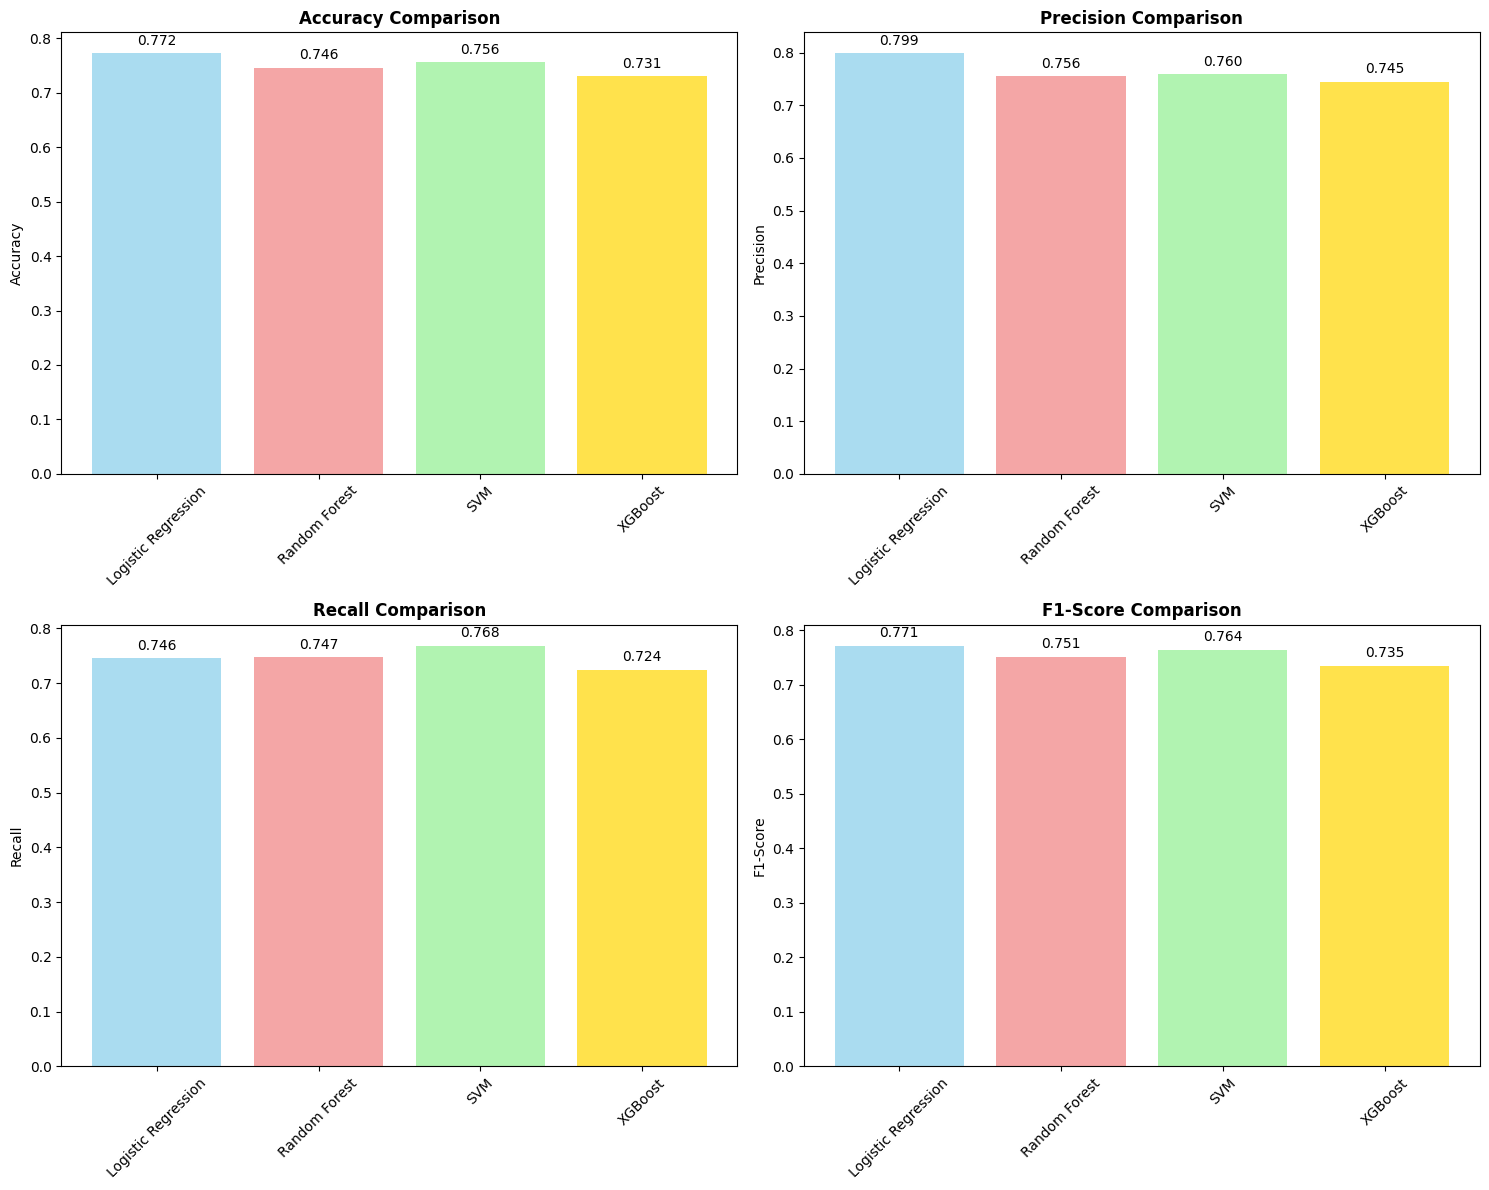

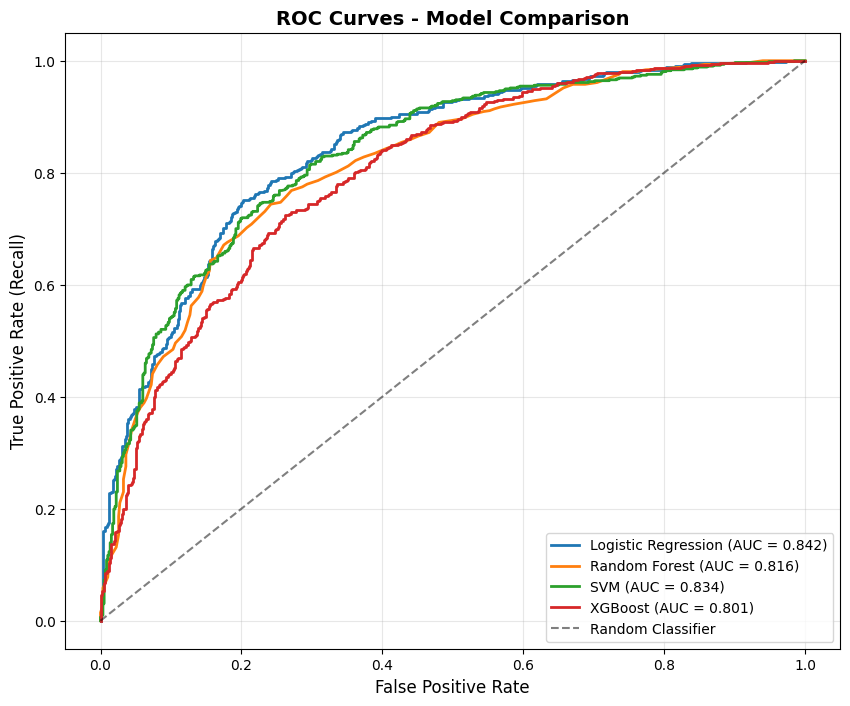

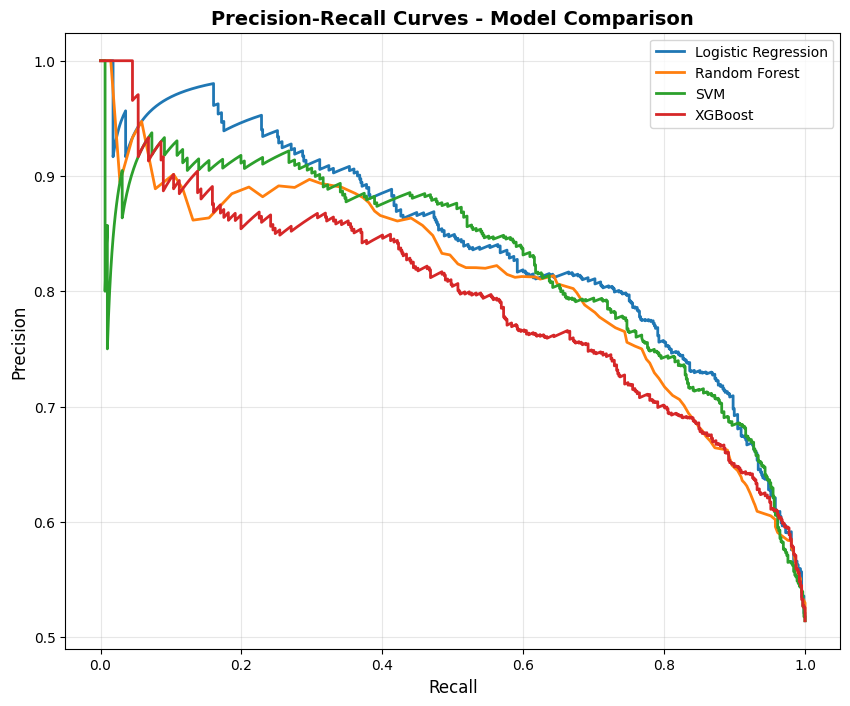


 FEATURE IMPORTANCE ANALYSIS
 Random Forest Feature Importance:
              feature  importance
0                 age    0.225672
3         cholesterol    0.216327
1         systolic_bp    0.198082
2        diastolic_bp    0.142385
4      pulse_pressure    0.141708
9          age_Middle    0.035854
10         age_Senior    0.027983
6   is_diastolic_high    0.006075
5    is_systolic_high    0.005647
8           age_Young    0.000267


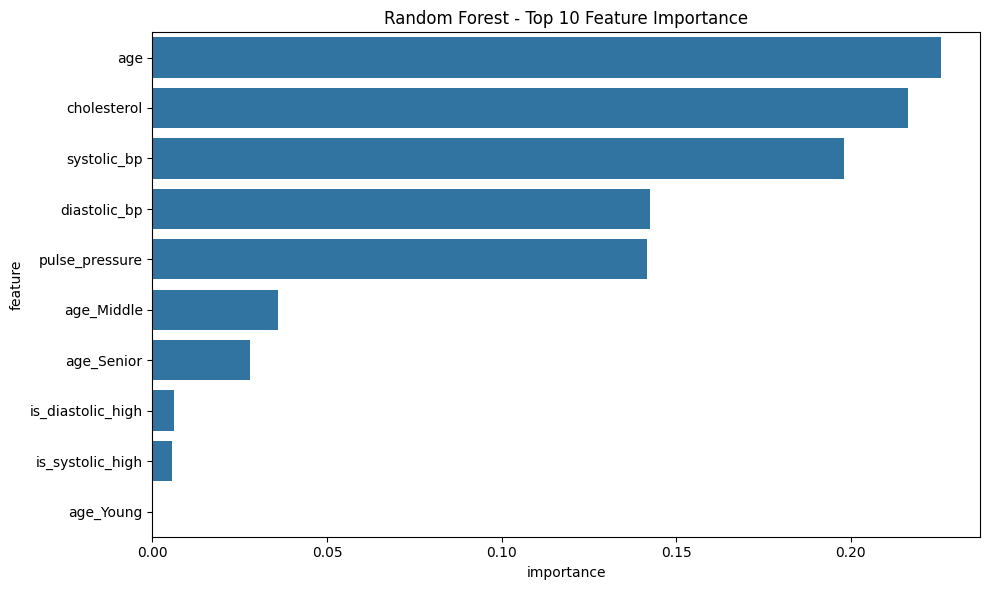

 XGBoost Feature Importance:
               feature  importance
0                  age    0.256326
3          cholesterol    0.206272
1          systolic_bp    0.196234
9           age_Middle    0.119489
2         diastolic_bp    0.112604
4       pulse_pressure    0.109075
5     is_systolic_high    0.000000
6    is_diastolic_high    0.000000
7  is_cholesterol_high    0.000000
8            age_Young    0.000000


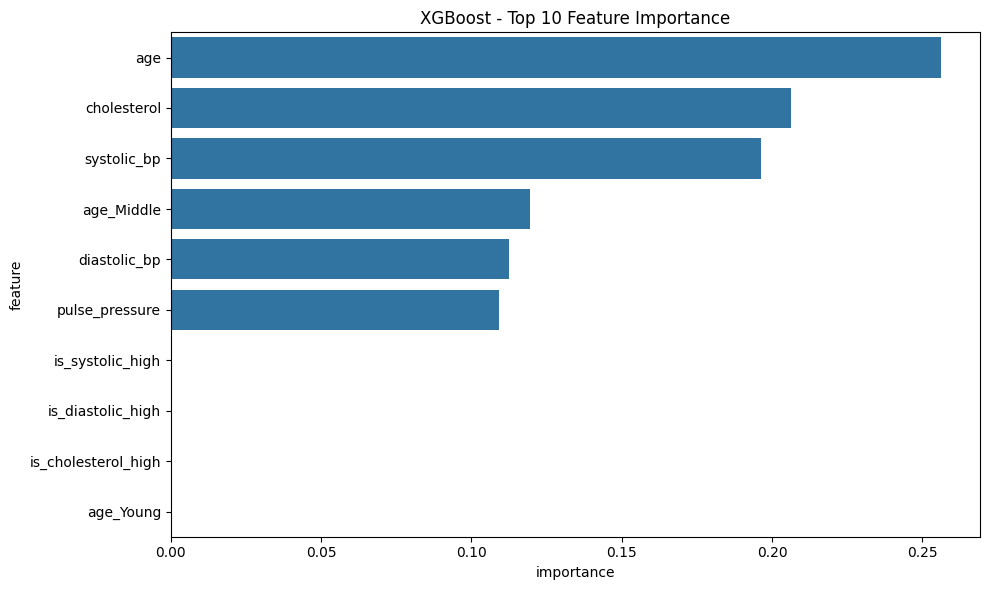

In [11]:
# 9.1 Model Comparison Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Metrics comparison
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']

for i, metric in enumerate(metrics_to_plot):
    row, col = i // 2, i % 2
    values = [comparison_df[comparison_df['Model'] == model][metric].values[0] for model in models.keys()]
    bars = axes[row, col].bar(models.keys(), values, color=colors, alpha=0.7)
    axes[row, col].set_title(f'{metric} Comparison', fontweight='bold')
    axes[row, col].set_ylabel(metric)
    axes[row, col].tick_params(axis='x', rotation=45)

    # Add value labels on bars
    for bar, v in zip(bars, values):
        axes[row, col].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                          f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 9.2 ROC Curves
plt.figure(figsize=(10, 8))
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['probabilities'])
    auc_score = result['auc']
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', alpha=0.5)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontweight='bold', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 9.3 Precision-Recall Curves
plt.figure(figsize=(10, 8))
for name, result in results.items():
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, result['probabilities'])
    plt.plot(recall_curve, precision_curve, label=f'{name}', linewidth=2)

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves - Model Comparison', fontweight='bold', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 9.4 Feature Importance for Tree-based models
print("\n FEATURE IMPORTANCE ANALYSIS")

if 'Random Forest' in results:
    rf_model = results['Random Forest']['model']
    feature_importance = pd.DataFrame({
        'feature': modeling_features,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print(" Random Forest Feature Importance:")
    print(feature_importance.head(10))

    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
    plt.title('Random Forest - Top 10 Feature Importance')
    plt.tight_layout()
    plt.show()

if 'XGBoost' in results:
    xgb_model = results['XGBoost']['model']
    xgb_importance = pd.DataFrame({
        'feature': modeling_features,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print(" XGBoost Feature Importance:")
    print(xgb_importance.head(10))

    plt.figure(figsize=(10, 6))
    sns.barplot(data=xgb_importance.head(10), x='importance', y='feature')
    plt.title('XGBoost - Top 10 Feature Importance')
    plt.tight_layout()
    plt.show()

### MODEL OPTIMIZATION

In [12]:
print(f"Performing hyperparameter tuning for best model: {best_model_name}")

best_model_results = results[best_model_name]

# Define parameter grids for each model
param_grids = {
    'Logistic Regression': {
        'C': [0.1, 1, 10, 100],
        'solver': ['liblinear', 'lbfgs'],
        'class_weight': ['balanced']
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'class_weight': ['balanced']
    },
    'SVM': {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto'],
        'class_weight': ['balanced']
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0]
    }
}

if best_model_name in param_grids:
    # Perform Grid Search with recall as scoring metric
    print(f"Performing Grid Search for {best_model_name}...")

    # Use appropriate data for the model
    if best_model_name in ['Logistic Regression', 'SVM']:
        X_opt = X_train_scaled
    else:
        X_opt = X_train

    grid_search = GridSearchCV(
        models[best_model_name].__class__(**{k: v for k, v in models[best_model_name].get_params().items()
                                           if k in param_grids[best_model_name]}),
        param_grids[best_model_name],
        cv=5,
        scoring='recall',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_opt, y_train)

    print(f" Best parameters: {grid_search.best_params_}")
    print(f" Best cross-validation recall: {grid_search.best_score_:.4f}")

    # Evaluate optimized model
    best_optimized_model = grid_search.best_estimator_
    if best_model_name in ['Logistic Regression', 'SVM']:
        y_pred_optimized = best_optimized_model.predict(X_test_scaled)
    else:
        y_pred_optimized = best_optimized_model.predict(X_test)

    recall_optimized = recall_score(y_test, y_pred_optimized)

    print(f"\n Optimized Model Performance:")
    print(f"   Recall (optimized): {recall_optimized:.4f}")
    print(f"   Recall (original):  {best_model_results['recall']:.4f}")
    print(f"   Improvement:        {recall_optimized - best_model_results['recall']:.4f}")

    # Update best model results
    results[best_model_name]['model'] = best_optimized_model
    results[best_model_name]['recall'] = recall_optimized

Performing hyperparameter tuning for best model: SVM
Performing Grid Search for SVM...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
 Best parameters: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 'auto'}
 Best cross-validation recall: 0.7648

 Optimized Model Performance:
   Recall (optimized): 0.7699
   Recall (original):  0.7682
   Improvement:        0.0016
